# Salary Predictions Based on Job Descriptions

**Author:**    Kevin O'Hara <br>
**Email:** kohara91@gmail.com <br>
**LinkedIn:**  https://www.linkedin.com/in/kevinodata/

Searching for jobs induces a sense of uncertainty. Will I find the right one? Will I enjoy my new responsibilities? And, of course, how will I be compensated? 

There are plenty of other things to consider, but this last aspect is something we can shed light on. There are online resources available to obtain this information, but we can also get an idea with machine learning. 

Using an imported list of job postings and their associated salaries, I will develop a model to predict a salary dependent on employee features. The model effectiveness will be evaulated by determining the mean squared error. This tool can prove useful for both businesses and individuals searching for new careers. An effective model can be used by HR to determine an adequate salary to offer to potential hires, and may also be used by individuals to request a reasonable salary. I will aim for a MSE less than 360 before testing and deploying this model. 

### Import Libraries

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import xgboost as xgb
import pickle
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from xgboost.sklearn import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

### Functions Used

In [245]:
# For cleaning data to remove $0 salaries
def clean_this(df):
    clean_this = df[df.salary>0]
    cleaned_df = clean_this.reset_index(drop=True)
    return cleaned_df
    
# For displaying distplots
def distribution_plot(real, predict, realLabel, predictLabel, title):
    plt.figure(figsize=(12,6))
    sns.distplot(real, hist=False, color='g', label = realLabel)
    sns.distplot(predict, hist=False, color='b', label = predictLabel)
    plt.xlabel('Salary')
    plt.ylabel('Probability Density Function')
    plt.title(title)
    plt.legend()
    
# For cleaning the test data
def finish_him(df):
    df.drop('companyId', axis=1, inplace=True)
    df.drop('jobId', axis=1, inplace=True)
    df = pd.get_dummies(df)
    scaler = StandardScaler()
    df.iloc[:,:2] = scaler.fit_transform(df.iloc[:,:2])
    return df

### Loading our datasets

In [265]:
train_salaries = pd.read_csv('data/train_salaries.csv')
train_job_postings = pd.read_csv('data/train_features.csv')
test_job_postings = pd.read_csv('data/test_features.csv')

### First Examination

In [174]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [175]:
train_salaries.shape

(1000000, 2)

In [176]:
train_salaries.isnull().any()

jobId     False
salary    False
dtype: bool

In [177]:
train_job_postings.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [178]:
train_job_postings.shape

(1000000, 8)

In [179]:
train_job_postings.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [180]:
train_job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


From here, I can verify that the data is loaded and see that there are 1,000,000 rows to work with. With .head and .info, I can see that most of the values are categorical, and that there are no missing values (no nulls). I will need to encode a fair amount of these features to get them ready to model. Fortunately, since there are no missing values, I will not need to impute any additional values.  

I can also see that the salaries and additional features are linked by a jobId. This allows me to stitch them together with the id to get them all on one dataframe.

The last dataset will be used at the end to make sure our final model can predict reasonable salaries with an additional set of new inputs.

### Cleaning/Pre-processing

The 'job_postings' dataframe (df) contains all of my features of interest. Of those features, 'jobType' and 'degree' are ordinal and could be encoded as such. I would assume that job roles higher in a company will have a higher salary, so CFO, CEO, CTO, and Vice_President would be ordered higher than Junior level positions. I would also assume that higher degrees will likely increase the potential salary.

For now, we will stitch the dfs together using jobId and make sure that our new df has values we would expect.

In [181]:
train_job_postings['jobType'].unique()

array(['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR',
       'CTO', 'SENIOR'], dtype=object)

In [182]:
train_job_postings['degree'].unique()

array(['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', 'NONE'],
      dtype=object)

In [183]:
train_job_postings['industry'].unique()

array(['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE'],
      dtype=object)

In [184]:
train_data = pd.merge(train_salaries, train_job_postings, on='jobId')

# Verify the merge occurred properly
train_data.head()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


Now that I've merged the dataframes, I will examine the whole table and make sure it's clean. The only tables that could be suspect are the numerical values - salary, yearsExperience, and milesFromMetropolis. The categorical features all have unique identifiers that make sense. I can check on the range of numerical values to see if it's normal.

In [185]:
train_data.describe()

,salary,yearsExperience,milesFromMetropolis
count,1e+06,1e+06,1e+06
mean,116.062,11.9924,49.5293
std,38.7179,7.21239,28.8777
min,0,0,0
25%,88,6,25
50%,114,12,50
75%,141,18,75
max,301,24,99


The range for all of the values seem reasonable except for the salary. There appear to be some \\$0 salaries. Since the goal of this model is to develop a way to predict salaries, I am better off removing the \\$0 salary rows. 

In [186]:
# Determine number of null salaries
no_salary = train_data['salary']<=0
bad_train_data = train_data[no_salary]
bad_train_data

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362684438246,0,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7
495984,JOB1362684903671,0,COMP34,JUNIOR,NONE,NONE,OIL,1,25
652076,JOB1362685059763,0,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
816129,JOB1362685223816,0,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
828156,JOB1362685235843,0,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29


There appear to be 5 with no salary. I will use the clean_this function to clear these values from the train_data and reset the index.

In [187]:
model_train_data = clean_this(train_data)
model_train_data.tail()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
999990,JOB1362685407682,88,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94
999991,JOB1362685407683,160,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35
999992,JOB1362685407684,64,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81
999993,JOB1362685407685,149,COMP3,CFO,MASTERS,NONE,HEALTH,6,5
999994,JOB1362685407686,88,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11


### Exploratory Data Analysis

In [188]:
model_train_data.describe()

,salary,yearsExperience,milesFromMetropolis
count,"999,995","999,995","999,995"
mean,116.062,11.9924,49.5294
std,38.7172,7.21239,28.8777
min,17,0,0
25%,88,6,25
50%,114,12,50
75%,141,18,75
max,301,24,99


These values appear to be reasonable. The training salaries range from 17 - 301 thousand with some clustering in the IQR, while the yearsExperience and milesFromMetropolis are pretty evenly spread in chunks of 6 and 25, respectively. The mean and std_dev seem appropirate for this as well.

In [189]:
model_train_data.nunique()

jobId                  999995
salary                    279
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
dtype: int64

There appears to be a unique jobId for each row. I will remove this feature as it will only generate noise in our model, if anything at all.

In [190]:
model_train_data.drop('jobId', axis=1, inplace=True)
model_train_data.head()

,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


I should now check to see if our target variable is normally distributed by examining the skew and kurtosis.

In [191]:
print('Skew:', model_train_data['salary'].skew())
print('Kurtosis:', model_train_data['salary'].kurt())

if -0.5 <= model_train_data['salary'].skew() <= 0.5 and -1 <= model_train_data['salary'].kurt() <= 1:
    print('The salary is normally distributed')
else:
    print('The salary is not normally distributed')

Skew: 0.34652727907668734
Kurtosis: -0.025750772283374967
The salary is normally distributed


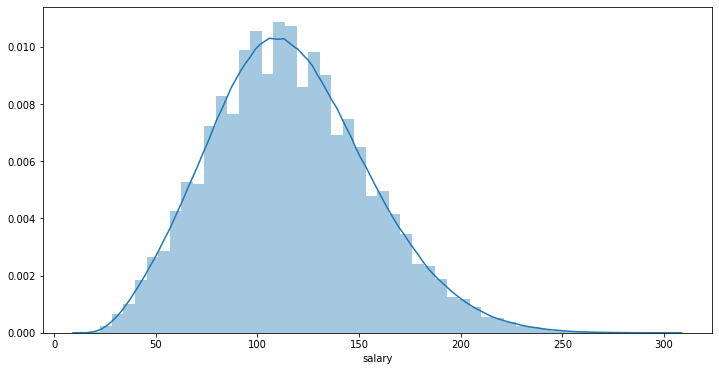

In [192]:
plt.figure(figsize=(12,6))
sns.distplot(model_train_data['salary'])

The target variable appears to be roughly normally distributed. Now I'll examine the relationship of this variable between the potential features: <br>
- companyId <br>
- jobType <br>
- degree <br>
- major <br>
- industry <br>
- yearsExperience <br>
- milesFromMetropolis

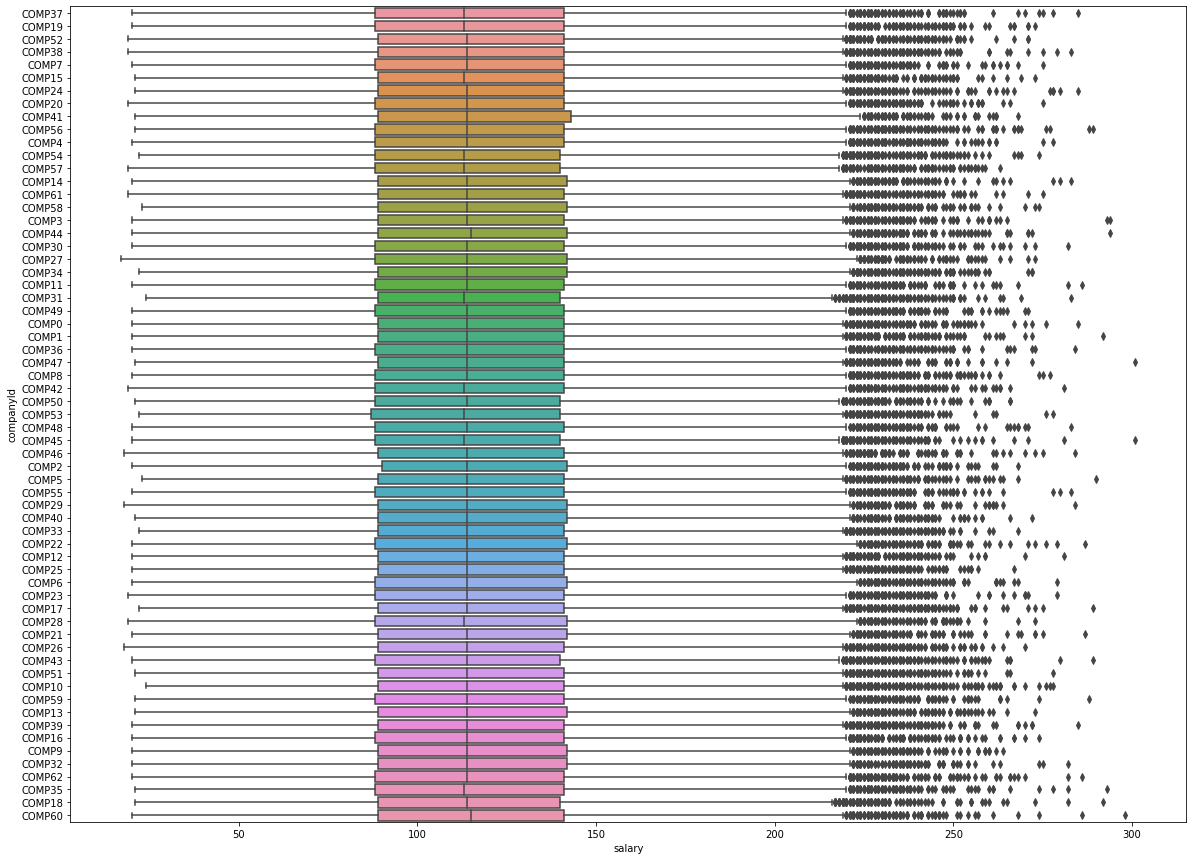

In [193]:
# companyId first. With 63 unique values, I'm skeptical to it's use here, so I'll use a boxplot to determine it's relationship
plt.figure(figsize=(20,15))
sns.boxplot(data=model_train_data, x='salary', y='companyId')

The salaries appear to be pretty evenly distributed by company. This tells me that the feature is not a good predictor, and is best removed from the df.

In [194]:
model_train_data.drop('companyId', axis=1, inplace=True)
model_train_data.head()

,salary,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,130,CFO,MASTERS,MATH,HEALTH,10,83
1,101,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,137,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,142,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,163,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


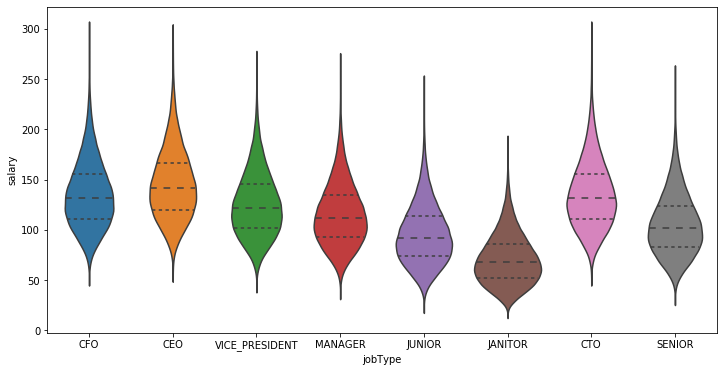

In [195]:
# jobType next.
plt.figure(figsize=(12,6))
sns.violinplot(data=model_train_data, x='jobType', y='salary', inner='quartile')

C-level positions appear to have the higher salary, and junior/janitor positions at the lowest. This appears to be a fairly important feature in the salary prediction. While this is expected, the above plot shows it's importance clearly.

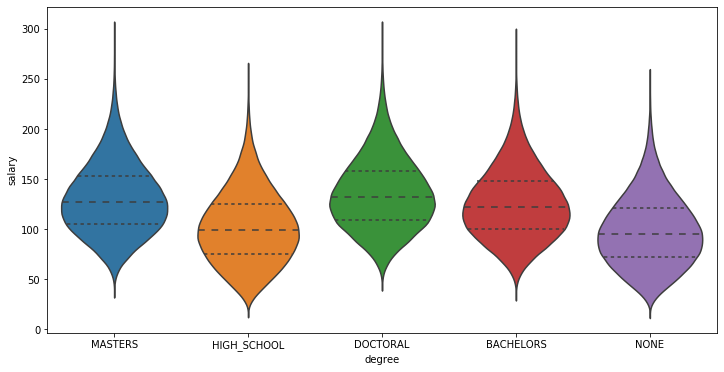

In [196]:
# degree next.
plt.figure(figsize=(12,6))
sns.violinplot(data=model_train_data, x='degree', y='salary', inner='quartile')

Higher education seems to equate to a higher salary, which lines up with my expectations. It's interesting to note that the median salary seems relatively stable with all higher-education degrees. There is a clear jump from none/high school to bachelors, and the masters/doctoral degrees are about on the same level.

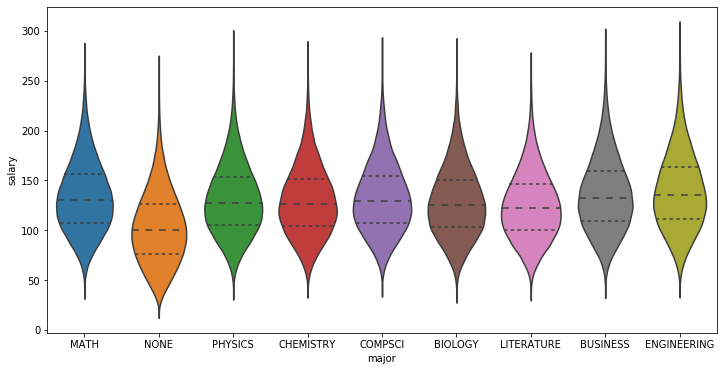

In [197]:
# major next.
plt.figure(figsize=(12,6))
sns.violinplot(data=model_train_data, x='major', y='salary', inner='quartile')

There appears to only be a noticable drop in salary when there is no degree. This is expected, but it is interesting to see that the median salary remains fairly consistent across all other majors.

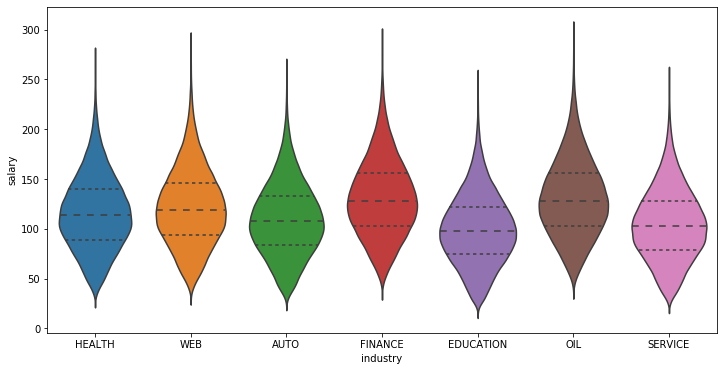

In [198]:
# industry next.
plt.figure(figsize=(12,6))
sns.violinplot(data=model_train_data, x='industry', y='salary', inner='quartile')

Finance and oil seem to have the highest salaries, which lines up with expectations. Auto, education, and service seem to have the lowest on average. 

(0, 150)

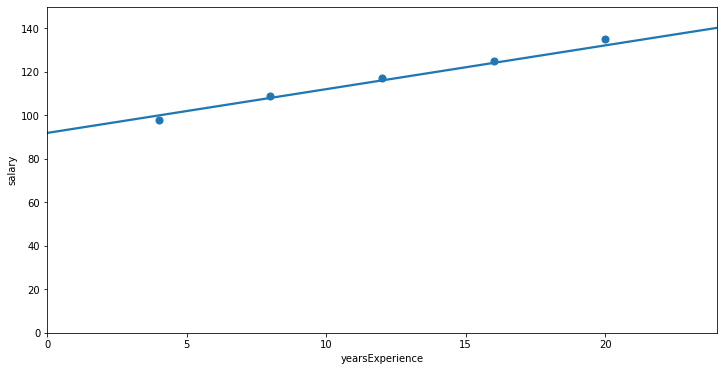

In [199]:
# yearsExperience next.
plt.figure(figsize=(12,6))
sns.regplot(data=model_train_data, x='yearsExperience', y='salary', x_bins=5)
plt.ylim(0,150)

There appears to be a slightly positive relationship between yearsExperience and salary

(0, 150)

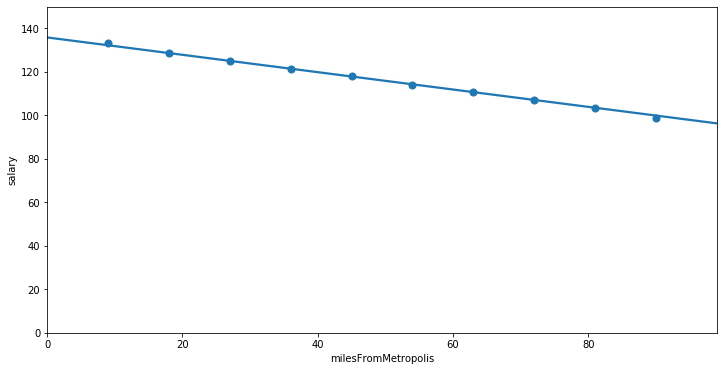

In [200]:
# milesFromMetropolis last.
plt.figure(figsize=(12,6))
sns.regplot(data=model_train_data, x='milesFromMetropolis', y='salary', x_bins=10)
plt.ylim(0,150)

This last feature gives a slight negative relationship between milesFromMetropolis and salary, which is about what I'd expect. Since cost of living increases as the proximity to a city increases, I would expect the salary to also increase.

### Summary

The target variable - salary - appears to be normally distributed with real values. <br> <br>
The remaining categorical features seem to impact the salary in important ways. I ultimately removed two features: jobId and companyId, as they seemed to have no impact on the actual salary. The jobId seemed to be a row identifier, and the 63 unique companyId's all had very similar salary ranges. The remaining features all seem to be useful predictors of salary. 

### First Simple Model

To prepare my first model, I will first need to encode the categorical features. I will do this using Pandas. Once it's encoded, I will then need to split our X and y dataframes. X will be all of the features, and y will just contain the salary.

In [201]:
model_train_data = pd.get_dummies(model_train_data)
model_train_data.head()

,salary,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,130,10,83,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,101,3,73,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,137,10,38,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,142,8,17,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,163,8,16,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [202]:
X = model_train_data[model_train_data.loc[:, model_train_data.columns != 'salary'].columns]
y = model_train_data['salary']

X.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,8,17,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [203]:
# The features all seem to be there. 
# All that's left is to split the data into train and test sets and scale the two numerical features.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train.iloc[:,:2] = scaler.fit_transform(X_train.iloc[:,:2])
X_test.iloc[:,:2] = scaler.transform(X_test.iloc[:,:2])

# Confirm that the scaling occured
X_train.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
784381,-0.968227,1.54072,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
851085,1.24875,-0.814129,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
90029,1.11019,1.15979,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
962495,1.66443,0.74423,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
657606,1.38731,0.051626,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


The first simple model will be a Linear Regression. This will be the most straightforward to create and should predict reasonably well for the continuous target variable.

In [204]:
# First I need to create the object and fit it to the training data.
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [205]:
# Predictions
y_predict = linear_model.predict(X_train)

The baseline for this model effectiveness is mean squared error (MSE). Now that I have some predictions, I can see how well the model works. I will also calculate the score or R^2 of the model, which measures how close the data is fitted to the regression line. The R^2 equates to the accuracy of the model.

In [206]:
print('MSE:', mean_squared_error(y_train, y_predict))
print('R^2:', linear_model.score(X_train, y_train))

MSE: 384.6575461712135
R^2: 0.7437143085560265


In [286]:
# 5fold CV Accuracy
five_fold = cross_val_score(linear_model, X_train, y_train, cv=5)
print('5fold accuracy:', five_fold.mean())

5fold accuracy: 0.7436940404901483


I can also use a distribution plot to visualize the accuracy of these predictions.

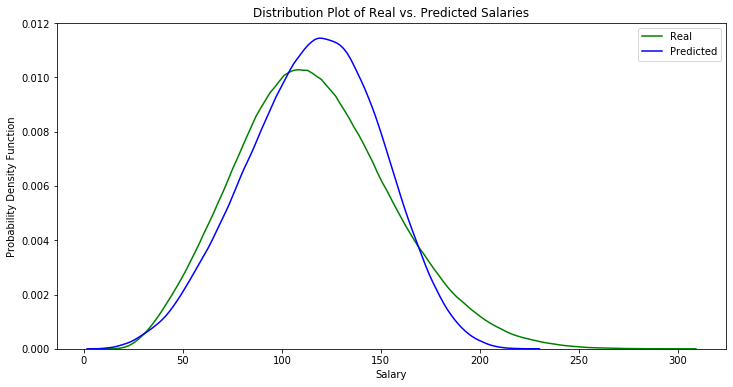

In [208]:
# Using a function created earlier
distribution_plot(y_train, y_predict, 'Real', 'Predicted', 'Distribution Plot of Real vs. Predicted Salaries')

The predictions seem fairly accurate. The mean is noticeably shifted slightly up. These plots seem to confirm the accuracy of the R^2 calculations earlier.

I will attempt to improve on the MSE with some more advanced models. The three that I'd like to try are:
<br>
 - Ridge Linear Regression
 - Support Vector Regression
 - Gradient Boosting using XGBoost

The Ridge method may prove more accurate than a simple linear regression and the Ridge regression process will keep me from overfitting. It will also allow me to examine the feature importance again with the coefficients.
<br><br>
Support Vector Regression with a linear kernel should work well with the large number of samples we have. From the EDA, the data seems to be organized well enough to model effectively with SVMs. 
<br><br>
Lastly, I will try a Gradient Boosting Regressor. This model tends to work very well for a wide variety of data sets, and this may be no different.


### Ridge Linear Regression

In [209]:
# First I will set the model
ridge_model = Ridge()

# Use GridSearchCV to tune hyperparameter
ridge_param_grid = {'alpha' : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 4, 5]}
ridge_final = GridSearchCV(ridge_model, ridge_param_grid, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)
print('Done fitting')

# Inspect the best alpha
print('Alpha:',ridge_final.best_params_['alpha'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    7.8s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    8.9s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    9.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished


Done fitting
alpha: 4


In [210]:
# Predictions and determine the accuracy of this model
ridge_predict = ridge_final.predict(X_train)

In [211]:
print('MSE:', mean_squared_error(y_train, ridge_predict))
print('R^2:', ridge_final.score(X_train, y_train))

MSE: 384.657543794627
R^2: 0.7437143101394743


The MSE and R^2 values are the same as the previous regression. Let's examine the coefficients of the Ridge regression to see if sheds light on relationships.

In [212]:
# Create the dataframe for storing coefficients.
col = list(X_train.columns)
ridge_coefs = pd.DataFrame(index=[0], columns=col)
pd.options.display.float_format = '{:,g}'.format

# Print the dataframe
ridge_dummy = Ridge(alpha=4)
ridge_dummy.fit(X_train, y_train)

ridge_coefs.iloc[0:1,:] = ridge_dummy.coef_
pd.set_option('display.max_columns', 31)
ridge_coefs

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_BACHELORS,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,degree_NONE,major_BIOLOGY,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,14.5043,-11.5283,27.7065,17.8912,17.8713,-34.6884,-22.1322,-2.17385,-12.1714,7.69675,0.0494021,10.0699,-5.72174,5.00949,-9.40707,-2.55701,5.24053,-1.39915,1.50835,8.16521,-6.07426,2.6716,-7.41348,-0.141779,-6.50256,-16.5367,14.5808,-0.333772,14.7663,-11.5212,5.54709


This tells me a lot about the importance of the features. By far, the most important features seem to be the jobType. They all have the largest Ridge coefficients in terms of absolute value. A C-level position seems to generate the largest positive increase in predicted salary, whereas Janitor and Junior predict a large decrease in salary. The next categorical feature with a large impact appears to be industry. Unfortunately, the education and service industries seem to produce the largest decreases in salary (education winning out) whereas finance and oil produce a very similar large increase in salary. The major and degree categorical features seem to be less impactful overall.

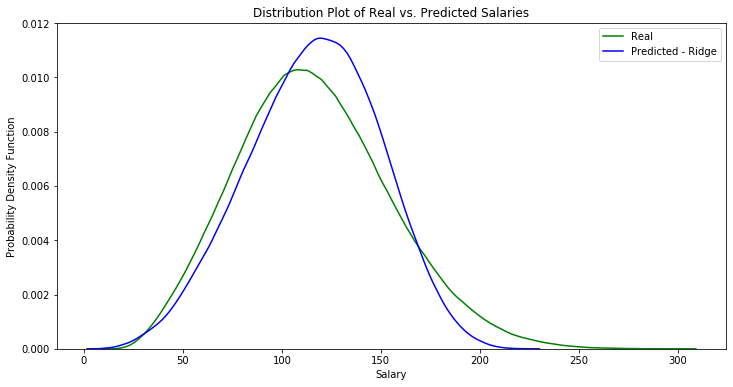

In [213]:
# Expecting the same plot
distribution_plot(y_train, ridge_predict, 'Real', 'Predicted - Ridge', 'Distribution Plot of Real vs. Predicted Salaries')

Ultimately, I saw no improvement with the Ridge regression. Next I'll see if SVR gives me a better model.

### Support Vector Regression

I'm choosing a Linear SVR model due to the large number of samples in this dataset.

In [214]:
# Set model
svr_model = LinearSVR(max_iter=100000)

# Setup GridSearchCV and fit with best params
svr_param_grid = {'C':[0.5, 1.0, 5, 10], 
                  'epsilon':[0, 0.1, 0.3, 0.5, 1]}
svr_final = GridSearchCV(svr_model, svr_param_grid, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)
print('Done fitting')

# Print best params
print('C:', svr_final.best_params_['C'])
print('epsilon:', svr_final.best_params_['epsilon'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:  1.3min remaining:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Done fitting
C: 5
epsilon: 0


In [215]:
# Determine SVR model accuracy
svr_predict = svr_final.predict(X_train)

print('MSE:', mean_squared_error(y_train, svr_predict))
print('R^2:', svr_final.score(X_train, y_train))

MSE: 385.83306203566195
R^2: 0.7429310978816949


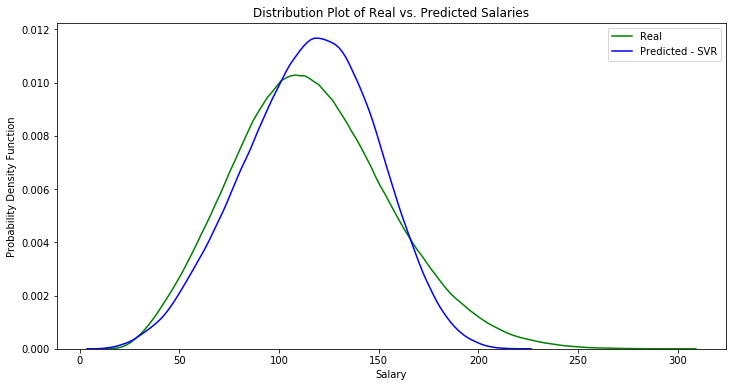

In [216]:
# Judging by the MSE I'm expecting a similar plot
distribution_plot(y_train, svr_predict, 'Real', 'Predicted - SVR', 'Distribution Plot of Real vs. Predicted Salaries')

Unfortunately, no real improvement with Linear SV Regression. I'll see if a Gradient Boosting model can make an impact.

### Gradient Boosting with XGBoost

In [218]:
# Start with a general XGB model
xgb1 = XGBRegressor(tree_method='exact',
                    predictor='cpu_predictor',
                    eval_metric='rmse',
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=5,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    seed=42)

# Determining the optimum number of trees (n_estimators) for this first learning rate. 
# This will be adjusted later on after setting the rest of the parameters.
xgb_params = xgb1.get_xgb_params()
xgb1 = xgb.DMatrix(X_train.values, label=y_train.values)
xgb_cv1 = xgb.cv(xgb_params, xgb1, num_boost_round=1000, nfold=5, 
                 metrics='rmse', early_stopping_rounds=25)
print('Best number of trees is:', xgb_cv1.shape[0])

Best number of trees is: 410


This tells me that the optimal number of best estimators with the current learning rate is 410. I will input that into the next model as I tune this further.

In [219]:
# Tune max_depth and min_child_weight
xgb2 = XGBRegressor(tree_method='exact',
                    predictor='cpu_predictor',
                    eval_metric='rmse',
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    n_estimators=410,
                    max_depth=5,
                    min_child_weight=5,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    seed=42)

xgb2_param = {'max_depth': [2, 4, 7],
              'min_child_weight': [1, 3, 5],}

# Grid search to find best params
xgb2_search = GridSearchCV(xgb2, xgb2_param, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)

print('Done fitting')
print('The best parameters here are:')
print('Max Depth:', xgb2_search.best_params_['max_depth'])
print('Min Child Weight:', xgb2_search.best_params_['min_child_weight'])

# Model accuracy
xgb2_predict = xgb2_search.predict(X_train)

print('MSE:', mean_squared_error(y_train, xgb2_predict))
print('R^2:', xgb2_search.score(X_train, y_train))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  27 out of  45 | elapsed: 16.6min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed: 27.9min remaining: 11.3min
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed: 31.0min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed: 33.0min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 36.6min finished


Done fitting
The best parameters here are:
Max Depth: 4
Min Child Weight: 3
MSE: 354.00143327841016
R^2: 0.7641395495734471


It looks as though the XGBRegressor has already outperformed the other models, and I still have a fair bit of tuning to go!

The optimal max depth and min child weight appear to be 4 and 3, respectively. Since the grid had every other odd/even value, I'll try another grid with one above and below the best parameters to fine tune it further.

In [220]:
xgb3 = XGBRegressor(tree_method='exact',
                    predictor='cpu_predictor',
                    eval_metric='rmse',
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    n_estimators=410,
                    max_depth=4,
                    min_child_weight=3,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    seed=42)

xgb3_param = {'max_depth': [3, 4, 5],
              'min_child_weight': [2, 3, 4],}

# Grid search to find best params
xgb3_search = GridSearchCV(xgb3, xgb3_param, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)

print('Done fitting')
print('The best parameters here are:')
print('Max Depth:', xgb3_search.best_params_['max_depth'])
print('Min Child Weight:', xgb3_search.best_params_['min_child_weight'])

# Determine MSE and accuracy
xgb3_predict = xgb3_search.predict(X_train)

print('MSE:', mean_squared_error(y_train, xgb3_predict))
print('R^2:', xgb3_search.score(X_train, y_train))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  27 out of  45 | elapsed: 20.4min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed: 24.9min remaining: 10.1min
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed: 29.3min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed: 30.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 31.5min finished


Done fitting
The best parameters here are:
Max Depth: 4
Min Child Weight: 3
MSE: 354.00143327841016
R^2: 0.7641395495734471


It appears as if 4 and 3 are the best values. I will set these in and now tune gamma.

In [221]:
xgb4 = XGBRegressor(tree_method='exact',
                    predictor='cpu_predictor',
                    eval_metric='rmse',
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    n_estimators=410,
                    max_depth=4,
                    min_child_weight=3,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    seed=42)

xgb4_param = {'gamma': [0.01, 0.1, 0.3, 0.5, 1]}

# Grid search to find best params
xgb4_search = GridSearchCV(xgb4, xgb4_param, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)

print('Done fitting')
print('The best parameter here is:')
print('Gamma:', xgb4_search.best_params_['gamma'])

# Determine MSE and accuracy
xgb4_predict = xgb4_search.predict(X_train)

print('MSE:', mean_squared_error(y_train, xgb4_predict))
print('R^2:', xgb4_search.score(X_train, y_train))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:  8.3min remaining: 33.0min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  8.3min remaining: 17.6min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:  8.3min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed: 16.4min remaining: 12.9min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed: 16.4min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed: 16.5min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed: 16.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 19.3min finished


Done fitting
The best parameter here is:
Gamma: 0.01
MSE: 354.00143327841016
R^2: 0.7641395495734471


Now that I have a few more set parameters, I will recalibrate the n_estimators.

In [222]:
xgb5 = XGBRegressor(tree_method='exact',
                    predictor='cpu_predictor',
                    eval_metric='rmse',
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=4,
                    min_child_weight=3,
                    gamma=0.01,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    seed=42)

# Determining the optimum number of trees (n_estimators)
xgb_params = xgb5.get_xgb_params()
xgb5 = xgb.DMatrix(X_train.values, label=y_train.values)
xgb_cv5 = xgb.cv(xgb_params, xgb5, num_boost_round=1000, nfold=5, 
                 metrics='rmse', early_stopping_rounds=25)
print('Best number of trees is:',xgb_cv5.shape[0])

Best number of trees is: 543


And now I can continue with tuning the subsample and colsample_bytree.

In [224]:
xgb6 = XGBRegressor(tree_method='exact',
                    predictor='cpu_predictor',
                    eval_metric='rmse',
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    n_estimators=543,
                    max_depth=4,
                    min_child_weight=3,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    seed=42)

xgb6_param = {'subsample': [0.2, 0.4, 0.6, 0.8],
              'colsample_bytree': [0.2, 0.4, 0.6, 0.8]}

# Grid search to find best params
xgb6_search = GridSearchCV(xgb6, xgb6_param, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)

print('Done fitting')
print('The best parameters here are:')
print('Subsample:', xgb6_search.best_params_['subsample'])
print('Max Features at Split:', xgb6_search.best_params_['colsample_bytree'])

# Determine MSE and accuracy
xgb6_predict = xgb6_search.predict(X_train)

print('MSE:', mean_squared_error(y_train, xgb6_predict))
print('R^2:', xgb6_search.score(X_train, y_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed: 43.1min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done  75 out of  80 | elapsed: 49.3min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 50.7min finished


Done fitting
The best parameters here are:
Subsample: 0.8
Max Features at Split: 0.4
MSE: 353.7605168780676
R^2: 0.7643000648859805


I'll tune these a bit further to see if I can improve.

In [225]:
xgb7 = XGBRegressor(tree_method='exact',
                    predictor='cpu_predictor',
                    eval_metric='rmse',
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    n_estimators=543,
                    max_depth=4,
                    min_child_weight=3,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=0.4,
                    seed=42)

xgb7_param = {'subsample': [0.7, 0.8, 0.9, 1],
              'colsample_bytree': [0.3, 0.4, 0.5]}

# Grid search to find best params
xgb7_search = GridSearchCV(xgb7, xgb7_param, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)

print('Done fitting')
print('The best parameters here are:')
print('Subsample:', xgb7_search.best_params_['subsample'])
print('Max Features at Split:', xgb7_search.best_params_['colsample_bytree'])

# Determine MSE and accuracy
xgb7_predict = xgb7_search.predict(X_train)

print('MSE:', mean_squared_error(y_train, xgb7_predict))
print('R^2:', xgb7_search.score(X_train, y_train))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed: 25.2min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed: 30.8min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed: 32.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 32.4min finished


Done fitting
The best parameters here are:
Subsample: 0.9
Max Features at Split: 0.3
MSE: 353.8500477720244
R^2: 0.7642404131586409


Lastly, I will set the learning rate and estimators again before locking in the final number of trees.

In [226]:
xgb8 = XGBRegressor(tree_method='exact',
                    predictor='cpu_predictor',
                    eval_metric='rmse',
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    n_estimators=543,
                    max_depth=4,
                    min_child_weight=3,
                    gamma=0.1,
                    subsample=0.9,
                    colsample_bytree=0.3,
                    seed=42)

xgb8_param = {'learning_rate': [0.0001, 0.001, 0.01, 0.1],
              'n_estimators': [200, 400, 600, 800]}

# Grid search to find best params
xgb8_search = GridSearchCV(xgb8, xgb8_param, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)

print('Done fitting')
print('The best parameters here are:')
print('Learning Rate:', xgb8_search.best_params_['learning_rate'])
print('N Estimators:', xgb8_search.best_params_['n_estimators'])

# Determine MSE and accuracy
xgb8_predict = xgb8_search.predict(X_train)

print('MSE:', mean_squared_error(y_train, xgb8_predict))
print('R^2:', xgb8_search.score(X_train, y_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed: 27.4min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  75 out of  80 | elapsed: 31.7min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 32.9min finished


Done fitting
The best parameters here are:
Learning Rate: 0.1
N Estimators: 800
MSE: 353.3169696363868
R^2: 0.7645955870007907


The learning rate is the same here so I will use this to test the number of estimators again for the final model

In [227]:
xgb9 = XGBRegressor(tree_method='exact',
                    predictor='cpu_predictor',
                    eval_metric='rmse',
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=4,
                    min_child_weight=3,
                    gamma=0.1,
                    subsample=0.9,
                    colsample_bytree=0.3,
                    seed=42)

# Determining the optimum number of trees (n_estimators)
xgb_params = xgb9.get_xgb_params()
xgb9 = xgb.DMatrix(X_train.values, label=y_train.values)
xgb_cv9 = xgb.cv(xgb_params, xgb9, num_boost_round=1000, nfold=5, 
                 metrics='rmse', early_stopping_rounds=25)
print('Best number of trees is:',xgb_cv9.shape[0])

Best number of trees is: 805


Great! Now I have the final XGB model. I will examine it's accuracy and plot for good measure.

In [228]:
xgb_final = XGBRegressor(tree_method='exact',
                         predictor='cpu_predictor',
                         eval_metric='rmse',
                         objective='reg:squarederror',
                         learning_rate=0.1,
                         n_estimators=805,
                         max_depth=4,
                         min_child_weight=3,
                         gamma=0.1,
                         subsample=0.9,
                         colsample_bytree=0.3,
                         seed=42)

xgb_final.fit(X_train, y_train)
xgb_predict = xgb_final.predict(X_train)

print('MSE:', mean_squared_error(y_train, xgb_predict))
print('R^2:', xgb_final.score(X_train, y_train))

MSE: 353.3075278545073
R^2: 0.7646018777745491


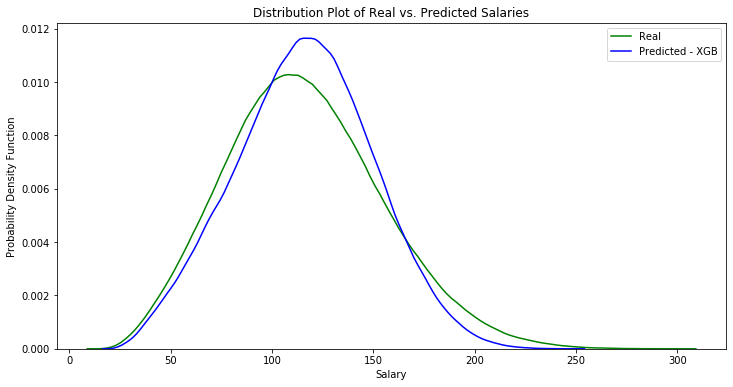

In [229]:
distribution_plot(y_train, xgb_predict, 'Real', 'Predicted - XGB', 'Distribution Plot of Real vs. Predicted Salaries')

The best model is certainly the XGB model. I will test it with the hold out dataset and see how it performs.

### Testing the final XGB model

First I will train the model on the whole training set, save it, and then use it to predict on the test set.

In [259]:
# Fit all training data to final model
xgb_final.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, eval_metric='rmse',
             gamma=0.1, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
             n_estimators=805, n_jobs=1, nthread=None,
             objective='reg:squarederror', predictor='cpu_predictor',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.9, tree_method='exact',
             verbosity=1)

In [260]:
with open ('xgb_salary_predict', 'wb') as f:
    pickle.dump(xgb_final, f)

In [261]:
with open ('xgb_salary_predict', 'rb') as f:
    xgb_test = pickle.load(f)

Now that the read-only model is loaded in, I will run and score it on the test data.

In [263]:
final_predict = xgb_test.predict(X_test)

print('MSE:', mean_squared_error(y_test, final_predict))

MSE: 353.63888060419043


This MSE is about as good as the MSE I received from the final training set. This is a good sign, and leads me to believe that the model acts as a reasonable predictor for future inputs. For good measure, I'll run this model on the hold out data set and observe a few of the predictions. Ideally, these predictions will be in the range of what I've seen already.

In [266]:
# First need to clean this, using a function described under the imported libraries.
new_test = finish_him(test_job_postings)

# Verify
new_test.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_BACHELORS,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,degree_NONE,major_BIOLOGY,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,1.38606,0.812524,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,1.10879,-0.0874503,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,0.692884,-1.4028,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.276979,1.60866,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,-0.277562,-0.191294,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [267]:
new_predict = xgb_test.predict(new_test)

new_predict[0:10]

array([111.30304 ,  92.72702 , 181.45908 , 104.35311 , 115.726776,
       153.8346  ,  97.741745, 117.56256 , 106.17886 ,  98.245125],
      dtype=float32)

These values are reasonable. Unfortunately, I have no actual salaries to test these against but I'm happy to see that these new inputs are providing outputs in the expected range.

### Summary

I have succeeded in building a predictive model for salary using some features about the job I am applying for. All I need to know is the years of experience, miles from downtown (metropolis), the job type, degree, major, and industry. This model will have value in both sides of the industry. For the business, this model will allow one to determine a reasonable salary in offer letters to potential new employees. For the individual, this model will help to determine if the offered salary is reasonable. The final predictive model has an MSE of roughly 353, improving on the starting model by more than 30, and improving in accuracy (R^2) by roughly 2%. 

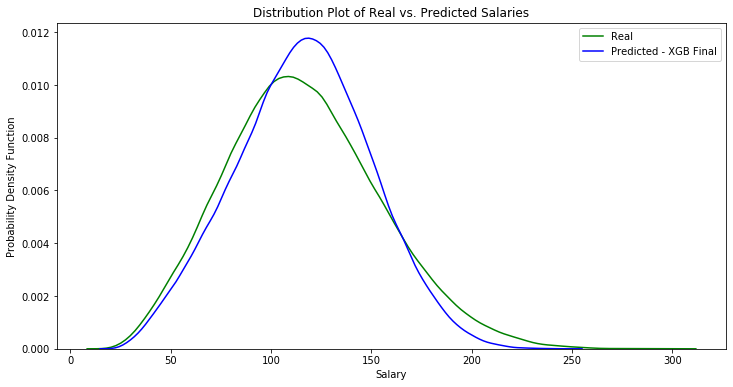

In [270]:
distribution_plot(y_test, final_predict, 'Real', 'Predicted - XGB Final', 'Distribution Plot of Real vs. Predicted Salaries')

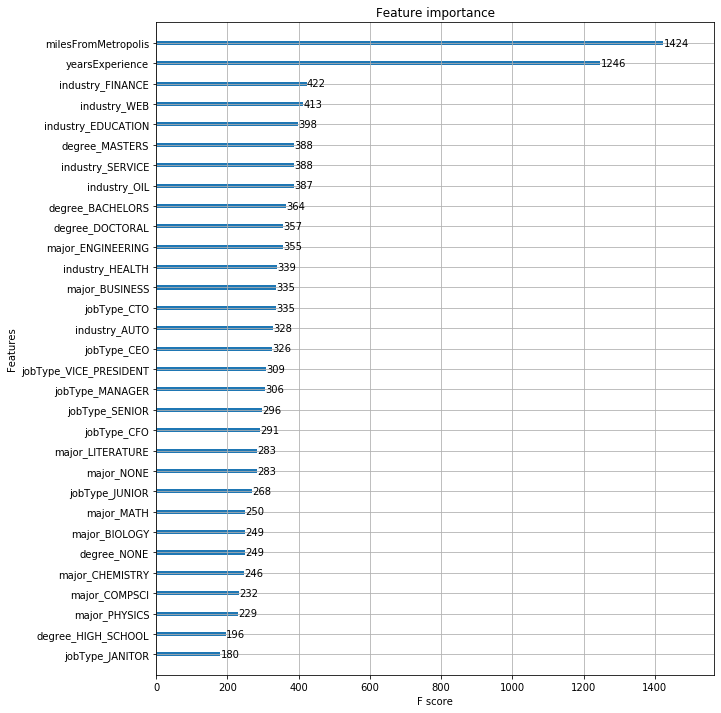

In [283]:
plt.rcParams['figure.figsize'] = (10,12)
xgb.plot_importance(xgb_final)
plt.show()

Interestingly enough, the job's proximity to a city (metropolis) and the candidate's years of experience seem to have an extremely large impact on salary relative to all of the other features. The industry has the next highest importance and job type, degree, and major all have similar importances. <br><br> Any questions or further discussion please feel free to reach out via email or LinkedIn. I am always open for new ideas to improve and would enjoy expanding our networks.